In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import toolz as tz
from collections import Counter
from operator import add
from functools import reduce
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import codecs
from fastText import train_supervised
from sklearn.metrics import precision_recall_fscore_support
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, Conv1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.rcParams["figure.figsize"] = (10,7)
import os
from fastText import load_model

In [4]:
plt.rcParams["figure.figsize"] = (10,7)

In [5]:
lyrics_data = pd.read_csv('lyrics.csv')
pop_data = pd.read_csv('lyricspop.csv')
print(pop_data.head())
lyrics_data = pd.concat([lyrics_data, pop_data], ignore_index=True)
lyrics_data.head()

            artist genre                                             lyrics  \
0  Michael Jackson   pop  \r\n\r\n[Verse 1]\r\nAs I drove across on the ...   
1  Michael Jackson   pop  \r\n\r\n[Verse 1]\r\nYou are the promised kiss...   
2  Michael Jackson   pop  \r\n\r\nHere come ol' flat top\r\nHe come groo...   
3  Michael Jackson   pop  \r\n\r\n[Chorus]\r\nTake me back\r\nTake me ba...   
4  Michael Jackson   pop  \r\n\r\n[Chorus]\r\nLove ain’t what it used to...   

                                      name  
0  a place with no name (original version)  
1                   all the things you are  
2                            come together  
3                             take me back  
4                          superfly sister  


,artist,genre,lyrics,name
0,Scorpions,rock,\r\n\r\n[Verse 1]\r\nI've been around the worl...,tease me please me
1,Scorpions,rock,"\r\n\r\n[Verse 1]\r\nWhat you give, you get ba...",what u give u get back
2,Scorpions,rock,"\r\n\r\nHey baby, listen up\r\nI'm not in love...",hate to be nice
3,Scorpions,rock,\r\n\r\n[Verse 1]\r\nWe come to you through a ...,we let it rock . . . you let it roll
4,Scorpions,rock,"\r\n\r\n[Verse 1]\r\nAnother morning, such as ...",kicks after six


## Preprocessing

In [6]:
def lyrics_reformat(lyrics):
    lyrics = lyrics.strip().split('\r\n')
    lyrics = [line for line in lyrics if line != '' and not line.startswith('[')]
    return ' '.join(lyrics).replace(",", "").replace(".", "").replace("-", " ").replace("\n", " ").lower()
lyrics_data['lyrics_reformatted'] = lyrics_data.lyrics.apply(lyrics_reformat)

In [7]:
def get_stats(preds, gts, labels):
    print("Overall Accuracy: {}".format(sum(preds == gts) / len(gts)))
    prf = precision_recall_fscore_support(preds, gts)
    for i in range(len(labels)):
        print("Precision for class {}: {}".format(labels[i], prf[0][i]))
        print("Recall for class {}: {}".format(labels[i], prf[1][i]))
        print("F1 for class {}: {}".format(labels[i], prf[2][i]))

In [144]:
def get_fp_tp_rates(thresh, labels, pred_probs, cls):
    preds = pred_probs > thresh
    preds = [pred[cls] for pred in preds]
    cmatrix = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cmatrix.ravel()
    return (fp / (tn + fp), tp / (tp + fn))


def get_as_x_y(model_rates):
    rates_as_list = list(zip(*model_rates))
    return rates_as_list[0], rates_as_list[1]

def show_roc(pred_probs, y_test_set):
    for i in genre_labels_reversed:
        rates = [get_fp_tp_rates(thresh, y_test_set==i, pred_probs, i) for thresh in np.arange(0.0, 1.0, 0.05)]
        x_roc, y_roc = get_as_x_y(rates)
        plt.plot(x_roc, y_roc, label=genre_labels_reversed[i], markerfacecolor='none')
    plt.legend()
    plt.show()

In [9]:
lyrics_data.head()

,artist,genre,lyrics,name,lyrics_reformatted
0,Scorpions,rock,\r\n\r\n[Verse 1]\r\nI've been around the worl...,tease me please me,i've been around the world i've known a lot of...
1,Scorpions,rock,"\r\n\r\n[Verse 1]\r\nWhat you give, you get ba...",what u give u get back,what you give you get back as long as i can th...
2,Scorpions,rock,"\r\n\r\nHey baby, listen up\r\nI'm not in love...",hate to be nice,hey baby listen up i'm not in love with you yo...
3,Scorpions,rock,\r\n\r\n[Verse 1]\r\nWe come to you through a ...,we let it rock . . . you let it roll,we come to you through a storm of lightning to...
4,Scorpions,rock,"\r\n\r\n[Verse 1]\r\nAnother morning, such as ...",kicks after six,another morning such as ordinary day she's doi...


In [10]:
lyrics_data.genre.unique()

array(['rock', 'country', 'rap', 'pop'], dtype=object)

In [11]:
genres = lyrics_data.genre.unique()
genre_labels = {genre: i for i,genre in enumerate(genres)}
genre_labels_reversed = {v: k for k, v in genre_labels.items()}
lyrics_data['genre_label'] = lyrics_data.genre.map(genre_labels)
lyrics_data.head()

,artist,genre,lyrics,name,lyrics_reformatted,genre_label
0,Scorpions,rock,\r\n\r\n[Verse 1]\r\nI've been around the worl...,tease me please me,i've been around the world i've known a lot of...,0
1,Scorpions,rock,"\r\n\r\n[Verse 1]\r\nWhat you give, you get ba...",what u give u get back,what you give you get back as long as i can th...,0
2,Scorpions,rock,"\r\n\r\nHey baby, listen up\r\nI'm not in love...",hate to be nice,hey baby listen up i'm not in love with you yo...,0
3,Scorpions,rock,\r\n\r\n[Verse 1]\r\nWe come to you through a ...,we let it rock . . . you let it roll,we come to you through a storm of lightning to...,0
4,Scorpions,rock,"\r\n\r\n[Verse 1]\r\nAnother morning, such as ...",kicks after six,another morning such as ordinary day she's doi...,0


We need to exclude some artists from training to properly test.

In [12]:
def get_random_artists(genre, n):
    lyrics_data_genre = lyrics_data[lyrics_data.genre == genre]
    artists = lyrics_data_genre.artist.unique()
    indeces = np.random.randint(len(artists), size=n)
    while len(set(indeces)) != n:
        indeces = np.random.randint(len(artists), size=n)
        
    return artists[indeces]
  
np.random.seed(2343)
artists_test = []
artists_val = []
for genre in lyrics_data.genre.unique():
    gotten_artists = list(get_random_artists(genre, 4))
    artists_test += gotten_artists[:2]
    artists_val += gotten_artists[2:]
    


In [13]:
lyrics_data_test_artists = lyrics_data[[artist in artists_test for artist in lyrics_data.artist]]
lyrics_data_val_artists = lyrics_data[[artist in artists_val for artist in lyrics_data.artist]]
lyrics_data_train_artists = lyrics_data[[(artist not in artists_test and artist not in artists_val) for artist in lyrics_data.artist]]


In [14]:
X = lyrics_data_train_artists.lyrics_reformatted
y = lyrics_data_train_artists.genre_label

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=684, test_size=0.125)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)
X_test_artists = lyrics_data_test_artists.lyrics_reformatted
y_test_artists = lyrics_data_test_artists.genre_label
X_val_artists = lyrics_data_val_artists.lyrics_reformatted
y_val_artists = lyrics_data_val_artists.genre_label

In [16]:
X_train.shape

(11698,)

In [17]:
X_test.shape

(836,)

In [18]:
X_val.shape

(836,)

## Bag of Words Approach

In [19]:
def get_most_common_words(lyric_list):
    all_words = []
    for lyrics in lyric_list:
        all_words += lyrics.split(" ")
    word_counts = sorted(tz.recipes.countby(lambda x: x, all_words).items(), key=lambda x: -x[1])
    return [wc[0] for wc in word_counts[0:200]]
    
word_counts_by_genre = {genre: get_most_common_words(X_train[y_train == genre_labels[genre]]) for genre in genre_labels}
    
features = []
for genre in genre_labels:
    words = word_counts_by_genre[genre]
    others = []
    for ogenre in genre_labels:
        if ogenre != genre: others += word_counts_by_genre[ogenre]
    features += [word for word in words if others.count(word) <= 1]

print(features)

['solution', 'city', 'provides', 'ability', 'respondent', 'must', 'any', 'service', 'hey', 'information', 'their', 'other', 'data', 'request', 'has', 'services', 'another', 'may', 'people', 'rock', 'ooh', 'provide', 'light', 'proposal', 'each', 'old', 'please', 'contractor', 'should', 'system', 'roll', 'work', 'its', 'la', 'requests', 'old', 'him', "i'd", "you'll", 'lord', 'blue', 'left', 'sweet', "he's", 'true', 'last', "you've", 'two', 'alone', 'mine', 'town', 'leave', 'woman', 'song', 'wrong', 'am', 'place', 'cry', 'those', 'big', 'another', 'has', 'found', 'their', 'fall', 'thought', 'hand', 'while', 'lonely', 'nigga', 'shit', 'niggas', 'fuck', 'ya', 'yo', 'bitch', 'people', 'money', "'em", 'put', 'ass', 'real', 'i’m', "y'all", 'gotta', 'music', 'hit', 'him', 'because', 'rock', 'big', 'black', 'two', 'game', 'show', 'talk', 'play', 'uh', 'rap', 'high', 'it’s', 'first', 'head', "let's", 'same', 'boy', 'god', 'watch', 'don’t', 'house', 'bad', 'mean', 'name', "gon'", 'everybody', 'don

In [20]:
def lyrics_to_features(features, lyrics):
    lyric_array = lyrics.split(" ")
    return {word: lyric_array.count(word) for word in features}

In [21]:
X_train_featurized = pd.DataFrame([lyrics_to_features(features, lyrics) for lyrics in X_train])
X_test_featurized = pd.DataFrame([lyrics_to_features(features, lyrics) for lyrics in X_test])
X_test_artists_featurized = pd.DataFrame([lyrics_to_features(features, lyrics) for lyrics in X_test_artists])
X_val_featurized = pd.DataFrame([lyrics_to_features(features, lyrics) for lyrics in X_val])
X_val_artists_featurized = pd.DataFrame([lyrics_to_features(features, lyrics) for lyrics in X_val_artists])
X_train_featurized.head()

,'em,ability,ah,alone,am,another,any,ass,bad,because,...,whole,without,woman,work,wrong,y'all,ya,yo,you'll,you've
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0


In [22]:
X_train_featurized.shape

(11698, 120)

In [23]:
rf = RandomForestClassifier(n_estimators=100, max_depth=40, random_state=3)
rf.fit(X_train_featurized, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

In [24]:
print("Stats on val same artists\n")
preds = rf.predict(X_val_featurized)
get_stats(preds, y_val, genre_labels_reversed)

print("\nStats on val new artists\n")
preds = rf.predict(X_val_artists_featurized)
get_stats(preds, y_val_artists, genre_labels_reversed)

print("\nStats on train")
preds = rf.predict(X_train_featurized)
get_stats(preds, y_train, genre_labels_reversed)

Stats on val same artists

Overall Accuracy: 0.6638755980861244
Precision for class rock: 0.5729166666666666
Recall for class rock: 0.5392156862745098
F1 for class rock: 0.5555555555555555
Precision for class country: 0.6338797814207651
Recall for class country: 0.5714285714285714
F1 for class country: 0.6010362694300518
Precision for class rap: 0.8768115942028986
Recall for class rap: 0.8581560283687943
F1 for class rap: 0.8673835125448028
Precision for class pop: 0.4702702702702703
Recall for class pop: 0.5918367346938775
F1 for class pop: 0.5240963855421686

Stats on val new artists

Overall Accuracy: 0.6190476190476191
Precision for class rock: 0.6363636363636364
Recall for class rock: 0.4666666666666667
F1 for class rock: 0.5384615384615385
Precision for class country: 0.5546218487394958
Recall for class country: 0.6055045871559633
F1 for class country: 0.5789473684210525
Precision for class rap: 0.8380952380952381
Recall for class rap: 0.9565217391304348
F1 for class rap: 0.89340

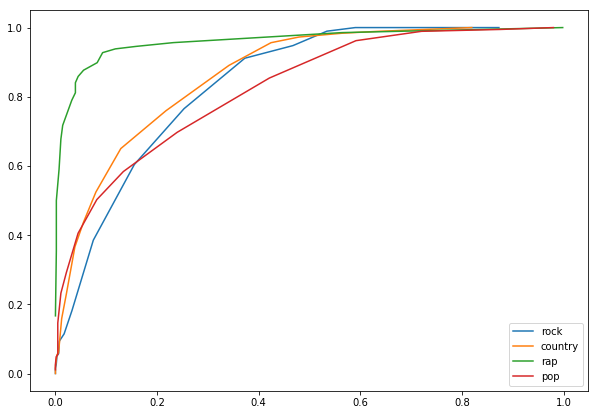

In [145]:
show_roc(rf.predict_proba(X_val_featurized), y_val)

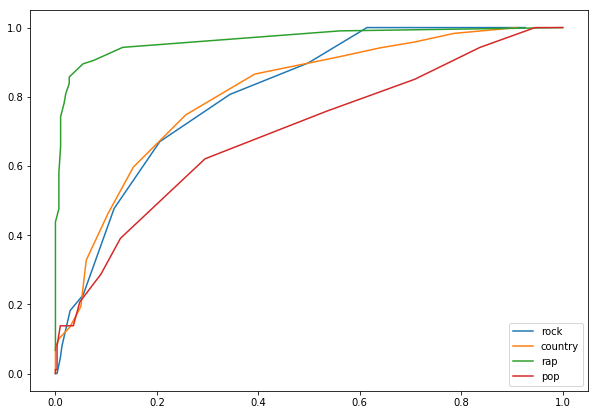

In [26]:
show_roc(rf.predict_proba(X_val_artists_featurized), X_val_artists_featurized, y_val_artists)

In [27]:
clf = MLPClassifier(solver='sgd', alpha=3, hidden_layer_sizes=(100, 100, 20), random_state=2, max_iter=1000)
clf.fit(X_train_featurized, y_train)

MLPClassifier(activation='relu', alpha=3, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=2, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [28]:
print("Stats on val same artists\n")
preds = clf.predict(X_val_featurized)
get_stats(preds, y_val, genre_labels_reversed)

print("\nStats on val new artists\n")
preds = clf.predict(X_val_artists_featurized)
get_stats(preds, y_val_artists, genre_labels_reversed)

print("\nStats on train artists")
preds = clf.predict(X_train_featurized)
get_stats(preds, y_train, genre_labels_reversed)

Stats on val same artists

Overall Accuracy: 0.6483253588516746
Precision for class rock: 0.4895833333333333
Recall for class rock: 0.5222222222222223
F1 for class rock: 0.5053763440860215
Precision for class country: 0.6284153005464481
Recall for class country: 0.5348837209302325
F1 for class country: 0.5778894472361807
Precision for class rap: 0.8695652173913043
Recall for class rap: 0.8571428571428571
F1 for class rap: 0.8633093525179856
Precision for class pop: 0.5027027027027027
Recall for class pop: 0.577639751552795
F1 for class pop: 0.5375722543352601

Stats on val new artists

Overall Accuracy: 0.5939849624060151
Precision for class rock: 0.6590909090909091
Recall for class rock: 0.48333333333333334
F1 for class rock: 0.5576923076923077
Precision for class country: 0.5630252100840336
Recall for class country: 0.6261682242990654
F1 for class country: 0.5929203539823009
Precision for class rap: 0.7333333333333333
Recall for class rap: 0.927710843373494
F1 for class rap: 0.819148

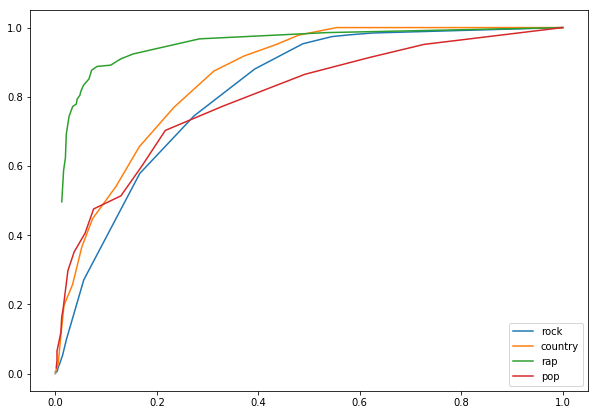

In [29]:
show_roc(clf.predict_proba(X_val_featurized), X_val_featurized, y_val)

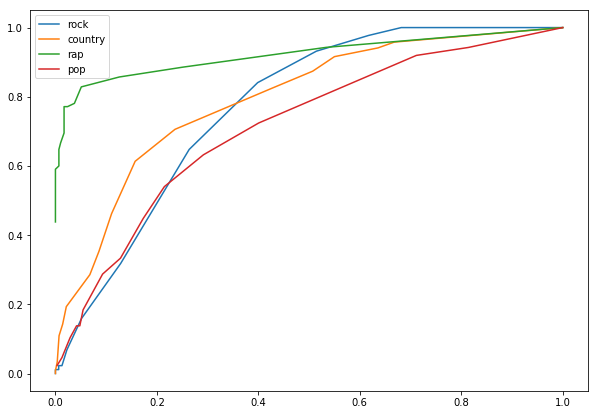

In [30]:
show_roc(clf.predict_proba(X_val_artists_featurized), X_val_artists_featurized, y_val_artists)

### FastText Approach

In [31]:
out_texts = ["__label__{} {}".format(genre_labels_reversed[y], x) for x, y in zip(X_train, y_train)]

file = codecs.open("lyrics.train", "w", "utf-8")
file.write('\n'.join(out_texts))
file.close()

In [36]:
print("WITHOUT PRETRAINED EMBEDDINGS")
for ng in range(1, 6):
    print("----------- NG: {} ------------".format(ng))
    if os.path.isfile("NG{}.weights".format(ng)):
        model = load_model("NG{}.weights".format(ng))
    else:
        model = train_supervised(
                input='lyrics.train', epoch=10, lr=1.0, wordNgrams=ng, minCount=1, dim=300, verbose=2
        )
        model.save_model("NG{}.weights".format(ng))
    print("Stats on val same artists\n")
    preds = [genre_labels[model.predict(x)[0][0].replace('__label__', '')] for x in X_val]
    get_stats(preds, y_val, genre_labels_reversed)
    print("\nStats on val new artists\n")
    preds = [genre_labels[model.predict(x)[0][0].replace('__label__', '')] for x in X_val_artists]
    get_stats(preds, y_val_artists, genre_labels_reversed)
    print("\nStats on train\n")
    preds = [genre_labels[model.predict(x)[0][0].replace('__label__', '')] for x in X_train]
    get_stats(preds, y_train, genre_labels_reversed)
    
print("USING PRETRAINED EMBEDDINGS") 
for ng in range(1, 6):
    print("----------- NG: {} ------------".format(ng))
    if os.path.isfile("NG{}_pretrained.weights".format(ng)):
        model = load_model("NG{}_pretrained.weights".format(ng))
    else:
        model = train_supervised(
            input='lyrics.train', epoch=10, lr=1.0, wordNgrams=ng, minCount=1, dim=300, verbose=2, pretrainedVectors="wiki.en.vec"
        )
        model.save_model("NG{}_pretrained.weights".format(ng))
    
    print("Stats on val same artists\n")
    preds = [genre_labels[model.predict(x)[0][0].replace('__label__', '')] for x in X_val]
    get_stats(preds, y_val, genre_labels_reversed)
    print("\nStats on val new artists\n")
    preds = [genre_labels[model.predict(x)[0][0].replace('__label__', '')] for x in X_val_artists]
    get_stats(preds, y_val_artists, genre_labels_reversed)
    print("\nStats on train\n")
    preds = [genre_labels[model.predict(x)[0][0].replace('__label__', '')] for x in X_train]
    get_stats(preds, y_train, genre_labels_reversed)

WITHOUT PRETRAINED EMBEDDINGS
----------- NG: 1 ------------
Stats on val same artists

Overall Accuracy: 0.757177033492823
Precision for class rock: 0.6770833333333334
Recall for class rock: 0.6989247311827957
F1 for class rock: 0.6878306878306879
Precision for class country: 0.7650273224043715
Recall for class country: 0.7650273224043715
F1 for class country: 0.7650273224043715
Precision for class rap: 0.8804347826086957
Recall for class rap: 0.8617021276595744
F1 for class rap: 0.870967741935484
Precision for class pop: 0.6486486486486487
Recall for class pop: 0.6486486486486487
F1 for class pop: 0.6486486486486487

Stats on val new artists

Overall Accuracy: 0.6541353383458647
Precision for class rock: 0.5909090909090909
Recall for class rock: 0.5909090909090909
F1 for class rock: 0.5909090909090909
Precision for class country: 0.5882352941176471
Recall for class country: 0.7142857142857143
F1 for class country: 0.6451612903225806
Precision for class rap: 0.8761904761904762
Recall 


Overall Accuracy: 0.7607655502392344
Precision for class rock: 0.6875
Recall for class rock: 0.6804123711340206
F1 for class rock: 0.6839378238341969
Precision for class country: 0.7540983606557377
Recall for class country: 0.7752808988764045
F1 for class country: 0.7645429362880887
Precision for class rap: 0.8804347826086957
Recall for class rap: 0.8741007194244604
F1 for class rap: 0.8772563176895307
Precision for class pop: 0.6648648648648648
Recall for class pop: 0.6612903225806451
F1 for class pop: 0.6630727762803235

Stats on val new artists

Overall Accuracy: 0.6491228070175439
Precision for class rock: 0.6136363636363636
Recall for class rock: 0.5684210526315789
F1 for class rock: 0.5901639344262295
Precision for class country: 0.5966386554621849
Recall for class country: 0.7319587628865979
F1 for class country: 0.6574074074074073
Precision for class rap: 0.8380952380952381
Recall for class rap: 0.9072164948453608
F1 for class rap: 0.8712871287128713
Precision for class pop: 0

In [159]:
model = load_model("NG{}.weights".format(3))


In [160]:
x_val_preds = [model.predict(x, k=4) for x in X_val]

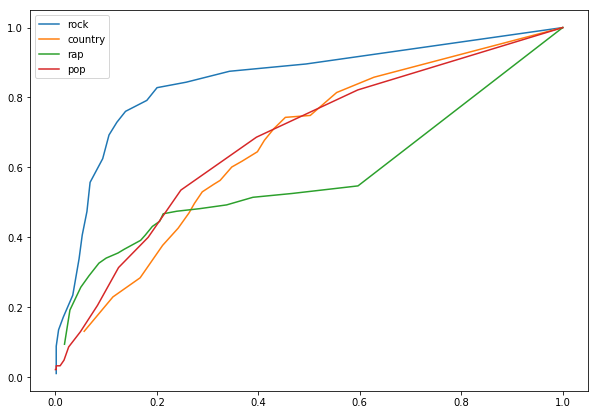

In [162]:
indeces = [[genre_labels[lab.replace("__label__", "")] for lab in cur_pred[0]] for cur_pred in x_val_preds]
preds = np.array([np.array(x_val_preds2[i][1][indeces[i]]) for i in range(len(x_val_preds))])
show_roc(preds, y_val)

In [38]:
max_features = 2000
embed_dim = 128
lstm_out = 100
X_train_shortened = np.array([x[:min(1000, len(x))] for x in X_train])

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X_train)
X_train_tokenized = tokenizer.texts_to_sequences(X_train_shortened)
X_train_tokenized = pad_sequences(X_train_tokenized, maxlen=200)
# X_train_tokenized = np.array(np.array(v[0:100]) for v in X_train_tokenized)
print(X_train_tokenized.shape)

(11698, 200)


In [181]:
def labels_to_onehot(labels):
    def to_onehot(x):
        return [0 if i != x else 1 for i in range(4)]
    return np.array([to_onehot(x) for x in labels])




model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X_train_tokenized.shape[1]))
model.add(Conv1D(filters=50, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.5))
model.add(LSTM(lstm_out, dropout=0.3, recurrent_dropout=0.4))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 128)          256000    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 200, 50)           19250     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200, 50)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 200, 100)          15100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 404       
Total para

In [116]:
print(X_train_tokenized.shape)

(12821, 200)


In [182]:
model.fit(X_train_tokenized, labels_to_onehot(y_train), batch_size=200, epochs=75)

Epoch 1/75
11698/11698 [==============================] - 41s 3ms/step - loss: 1.3788 - acc: 0.2995
Epoch 2/75
11698/11698 [==============================] - 37s 3ms/step - loss: 1.3280 - acc: 0.3229
Epoch 3/75
11698/11698 [==============================] - 36s 3ms/step - loss: 1.1117 - acc: 0.4718
Epoch 4/75
11698/11698 [==============================] - 36s 3ms/step - loss: 1.0740 - acc: 0.4918
Epoch 5/75
11698/11698 [==============================] - 36s 3ms/step - loss: 1.0364 - acc: 0.5141
Epoch 6/75
11698/11698 [==============================] - 36s 3ms/step - loss: 1.0101 - acc: 0.5306
Epoch 7/75
11698/11698 [==============================] - 36s 3ms/step - loss: 0.9951 - acc: 0.5368
Epoch 8/75
11698/11698 [==============================] - 36s 3ms/step - loss: 0.9780 - acc: 0.5468
Epoch 9/75
11698/11698 [==============================] - 36s 3ms/step - loss: 0.9569 - acc: 0.5647
Epoch 10/75
11698/11698 [==============================] - 36s 3ms/step - loss: 0.9363 - acc: 0.5869

Overall Accuracy: 0.7212918660287081
Precision for class rock: 0.546875
Recall for class rock: 0.6104651162790697
F1 for class rock: 0.5769230769230769
Precision for class country: 0.7650273224043715
Recall for class country: 0.6635071090047393
F1 for class country: 0.7106598984771574
Precision for class rap: 0.8659420289855072
Recall for class rap: 0.8690909090909091
F1 for class rap: 0.867513611615245
Precision for class pop: 0.6432432432432432
Recall for class pop: 0.6685393258426966
F1 for class pop: 0.6556473829201102


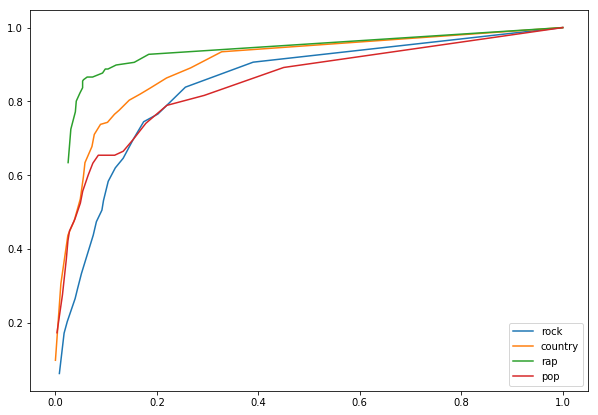

In [186]:
X_val_shortened = np.array([x[:min(1000, len(x))] for x in X_val])
prob_preds = model.predict(pad_sequences(tokenizer.texts_to_sequences(X_val_shortened), maxlen=200))
get_stats(np.argmax(prob_preds, axis=-1), y_val, genre_labels_reversed)
show_roc(prob_preds, y_val)

Overall Accuracy: 0.6140350877192983
Precision for class rock: 0.5340909090909091
Recall for class rock: 0.5340909090909091
F1 for class rock: 0.5340909090909091
Precision for class country: 0.6050420168067226
Recall for class country: 0.6260869565217392
F1 for class country: 0.6153846153846154
Precision for class rap: 0.7904761904761904
Recall for class rap: 0.8645833333333334
F1 for class rap: 0.8258706467661692
Precision for class pop: 0.4942528735632184
Recall for class pop: 0.43
F1 for class pop: 0.45989304812834225


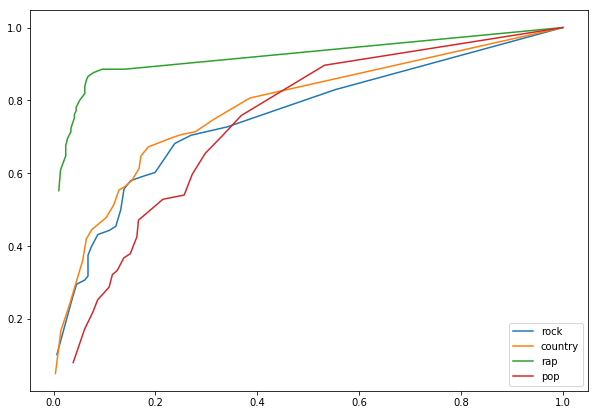

In [185]:
X_val_shortened = np.array([x[:min(1000, len(x))] for x in X_val_artists])
prob_preds = model.predict(pad_sequences(tokenizer.texts_to_sequences(X_val_shortened), maxlen=200))
get_stats(np.argmax(prob_preds, axis=-1), y_val_artists, genre_labels_reversed)
show_roc(prob_preds, y_val_artists)

In [76]:
blah = [len(x.split(' ')) for x in X_train]
blah = blah[0:226] + blah[227:]
max(blah)

32944

In [127]:
model.optimizer.get_

AttributeError: 'Tensor' object has no attribute 'value'